In [1]:
%load_ext autoreload
%autoreload 2
import os
import src.ftrs.feature_generator as fgen
import src.mex.regions2010 as mex_region
import src.mex.census2010 as mex_census
import src.mex.crime as mex_crime

In [2]:
from scipy.stats import spearmanr, pearsonr

In [3]:
import statsmodels.api as sm


In [4]:
%matplotlib inline

In [5]:
import exp_pred_muni_crime as exp_predc
import src.exp.preprocessing as exp_prep
import src.exp.sklearn_models as exp_sk
import pandas as pd

In [6]:
from IPython.display import display

In [20]:
settings = {
    2: ('UrbanRural', 'grid-500', 'Uni'),  # running
    0: ('Urban', 'grid-500', 'Uni'),  # done
    1: ('Urban', 'grid-500', 'Pop'),  # done
    3: ('Urban', 'ageb', 'Uni'),
    4: ('Urban', 'ageb', 'Pop'),
}

boundary_type, su_type, intpl = settings[0]
print(boundary_type, su_type, intpl)
db_path = 'data/features_database.json'

Urban grid-500 Uni


# load data

In [21]:
crimes = exp_predc.load_crime()

In [22]:
features = exp_predc.load_feature(db_path, boundary_type, su_type, intpl, mun_ids=crimes.index)
features = exp_prep.fillna(features)

In [23]:
income = mex_census.income_indigenous_group()
poverty = mex_census.poverty_munic(kind='poverty', rate=True)
econ_unoccupied = mex_census.econ_active_unoccupied(rate=True)
mgms = mex_region.municipalities(load_pop=True)

In [24]:
features.columns

Index(['loubar-NHS-all_day', 'loubar-NHS-home_hour', 'loubar-NHS-work_hour',
       'loubar-NHS-hour0', 'loubar-NHS-hour1', 'loubar-NHS-hour2',
       'loubar-NHS-hour3', 'loubar-NHS-hour4', 'loubar-NHS-hour5',
       'loubar-NHS-hour6',
       ...
       'loubar-NMMI-hour14', 'loubar-NMMI-hour15', 'loubar-NMMI-hour16',
       'loubar-NMMI-hour17', 'loubar-NMMI-hour18', 'loubar-NMMI-hour19',
       'loubar-NMMI-hour20', 'loubar-NMMI-hour21', 'loubar-NMMI-hour22',
       'loubar-NMMI-hour23'],
      dtype='object', length=216)

In [128]:
to_r=crimes[['#pro']].join( features[[
    'loubar-NHS-all_day','loubar-AHS-all_day','loubar-COMP-all_day',
    'loubar-MCOMP-all_day','loubar-PROX-all_day','loubar-COHE-all_day',
    'loubar-NMI-all_day','loubar-NMMI-all_day']])
to_r.columns=['pro_cnt','nhs','ahs','comp','mcomp', 'prox','cohe', 'nmi', 'nmmi']
to_r = to_r.join(poverty).join(econ_unoccupied).join(income)
to_r.index.name='Identifier'
to_r['popu'] = mgms.pobtot

In [26]:
true_crime = pd.read_csv('data/ddexp-posterier_mean_estimate.csv', index_col=0).reset_index(drop=True)

In [27]:
to_r['income_group'] = pd.qcut(to_r['aver_income'], 4, labels=False)


In [28]:
to_r['y'] = true_crime['y'].values
to_r['z'] = true_crime['z'].values
to_r['pro/z'] = to_r.pro_cnt/to_r.z

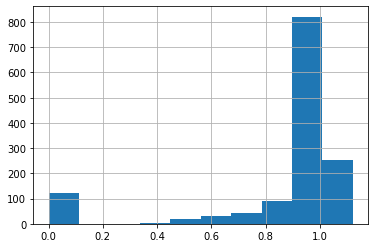

In [29]:
to_r['pro/z'].hist()

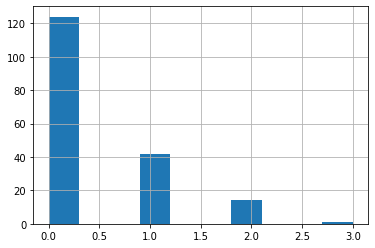

In [30]:
to_r[to_r['pro/z']<0.7].pro_cnt.hist()

# run model

In [101]:

training = to_r.iloc[:1103].copy()
testing = to_r.iloc[1103:].copy()

# train_idx, test_idx = train_test_split(list(range(len(to_r))), test_size=0.2, random_state=301381)
# training = to_r.iloc[train_idx].copy()
# testing = to_r.iloc[test_idx].copy()

nhs_min = training.nhs.min()
nhs_range = training.nhs.max()-nhs_min

training.nhs = (training.nhs - nhs_min) / nhs_range
testing.nhs = (testing.nhs - nhs_min) / nhs_range

train_result_compare = training[['pro_cnt', 'y', 'aver_income','PI_type', 'income_group']].copy()
test_result_compare = testing[['pro_cnt', 'y', 'aver_income','PI_type', 'income_group']].copy()

In [16]:
c1 = pd.read_csv('data/chain1.csv.gz',index_col=0).iloc[:,:9]
c2 = pd.read_csv('data/chain2.csv.gz',index_col=0).iloc[:,:9]
c3 = pd.read_csv('data/chain3.csv.gz',index_col=0).iloc[:,:9]
c4 = pd.read_csv('data/chain4.csv.gz',index_col=0).iloc[:,:9]


In [17]:
chain = pd.concat([c1,c2,c3,c4])

In [34]:
ftr = ['nhs','ahs','comp','mcomp', 'prox','cohe', 'nmi', 'nmmi']

train_X = training[['nhs','prox','comp','poverty_rate','active_unoccupied']].values
# train_X = training[ftr].values
train_Y = training['pro_cnt'].values
test_X = testing[['nhs','prox','comp','poverty_rate','active_unoccupied']].values
# test_X = testing[ftr].values
test_Y = testing['pro_cnt'].values
dataset = (train_X, test_X, train_Y, test_Y)

In [68]:
ftr_b0 = pd.Series([1] * len(testing))

ftr_b1 = pd.np.log(testing.active_unoccupied).reset_index(drop=True)
ftr_b2 = pd.np.log(testing.poverty_rate).reset_index(drop=True)
ftr_b = pd.concat([ftr_b0, ftr_b1, ftr_b2], axis=1)

In [67]:
ftr_a0 = pd.Series([1] * len(testing))
ftr_a1 = pd.np.log(testing.nhs+0.001).reset_index(drop=True)
ftr_a2 = testing.prox.reset_index(drop=True)
ftr_a3 = pd.np.log(testing.comp+0.001).reset_index(drop=True)
ftr_a = pd.concat([ftr_a0, ftr_a1, ftr_a2, ftr_a3], axis=1)

In [19]:
chain.mean()

a[1]            5.758013
a[2]            0.784724
a[3]           -3.246692
a[4]           -0.570092
b[1]            0.188889
b[2]            0.385004
b[3]           -1.254957
epsilon         1.537528
lambda[1]    8047.779614
dtype: float64

In [70]:
chain.mean()[:4].values

array([ 5.75801333,  0.78472355, -3.2466924 , -0.57009186])

In [94]:
test_lam = pd.np.exp((ftr_a*chain.mean()[:4].values).sum(axis=1))
test_lam

0      130.941289
1      235.632223
2      101.592245
3       65.660021
4      214.087793
          ...    
271     95.334810
272    300.401368
273    544.729726
274    366.346772
275    519.215990
Length: 276, dtype: float64

In [95]:
def inv_logit(p):
    return pd.np.exp(p) / (1 + pd.np.exp(p))

In [96]:
test_pi = inv_logit((ftr_b*chain.mean()[4:7].values).sum(axis=1))

In [97]:
test_z = test_lam * test_pi

In [98]:
test_z

0        7.102616
1        6.472281
2        0.929631
3        2.155198
4       18.355365
          ...    
271     17.726958
272     21.187975
273     34.046230
274     35.868550
275    152.802470
Length: 276, dtype: float64

In [99]:
(testing.pro_cnt.reset_index(drop=True)-test_z).abs().mean()

189.01595468511368

In [119]:
test_z.index=test_result_compare.index

In [120]:
test_result_compare['pro_cnt_pred'] = test_z

# comparing result

In [103]:
def compute_error(df, col):
    true = df[col]
    pred = df[f'{col}_pred']
    
    df[f'{col}_SE'] = (true - pred)**2
    df[f'{col}_E'] = true - pred
    df[f'{col}_AE'] = df[f'{col}_E'].abs()


In [122]:
# compute_error(train_result_compare, 'y')
# compute_error(train_result_compare, 'pro_cnt')
# compute_error(test_result_compare, 'y')
compute_error(test_result_compare, 'pro_cnt')

In [105]:
norm_factor = {'pro_cnt':{'raw':1}, 'y':{'raw':1}}
norm_factor['pro_cnt']['mean'] = train_result_compare.pro_cnt.mean()
norm_factor['pro_cnt']['max_min'] = train_result_compare.pro_cnt.max() - train_result_compare.pro_cnt.min()
norm_factor['pro_cnt']['quartile'] = train_result_compare.pro_cnt.quantile(.75, interpolation='nearest') - train_result_compare.pro_cnt.quantile(.25, interpolation='nearest')

norm_factor['y']['mean'] = train_result_compare.y.mean()
norm_factor['y']['max_min'] = train_result_compare.y.max() - train_result_compare.y.min()
norm_factor['y']['quartile'] = train_result_compare.y.quantile(.75, interpolation='nearest') - train_result_compare.y.quantile(.25, interpolation='nearest')
pd.DataFrame(norm_factor)

,pro_cnt,y
raw,1.000000,1.000000
mean,269.639166,721.737220
max_min,17655.000000,30796.056525
quartile,71.000000,415.487625


In [106]:
def norm_err(df, col, nfact):
    rmse = pd.np.sqrt(df[col+'_SE'].mean())
    mae = df[col+'_AE'].mean()
    me_neg = df[df[col+'_E']<0][col+'_E'].mean()
    me_pos = df[df[col+'_E']>0][col+'_E'].mean()
    ne_zero = (df[col+'_E']==0).sum()
    
    norm = {('ne_zero','raw'): ne_zero}
    for fact_name, fact in nfact[col].items():
        norm[('rmse', fact_name)] = rmse/fact
        norm[('mae', fact_name)] = mae/fact
        norm[('me_neg', fact_name)] = me_neg/fact
        norm[('me_pos', fact_name)] = me_pos/fact
    return norm

In [124]:
overall_err = {}
# overall_err['train_y'] = norm_err(train_result_compare, 'y', norm_factor)
# overall_err['test_y'] = norm_err(test_result_compare, 'y',norm_factor)
# overall_err['train_pro_cnt'] = norm_err(train_result_compare, 'pro_cnt',norm_factor)
overall_err['test_pro_cnt'] = norm_err(test_result_compare, 'pro_cnt',norm_factor)

In [108]:
def group_norm_err(df, col, nfact,gtype='PI_type'):
    return pd.DataFrame(df.groupby(gtype).apply(lambda df: norm_err(df, col, nfact)).to_dict()).sort_index().T


In [109]:
def get_error_for_a_type(eall, egroup, etype, disp=True, return_df=True):
    eall_df = pd.DataFrame(eall).sort_index().T[etype].to_frame().T
    
    egrp_df = []
    for k, df in egroup.items():
        t = df[etype].copy()
        t.name = k
        egrp_df.append(t)
    egrp_df = pd.concat(egrp_df, axis=1, sort=False)
    egrp_df.index.name = f'{etype[0]}/{etype[1]}'
    egrp_df

    egrp_std = {}
    for i in ['train', 'test']:
        egrp_std[i]={}
        for j in ['y','pro_cnt']:
            egrp_std[i][j]=egrp_df.std()[i+'_'+j]

    egrp_std = pd.DataFrame(egrp_std).T
    egrp_std.index.name = f'{etype[0]}/{etype[1]} std'
    
    egrp_std_by_mean = {}
    for i in ['train', 'test']:
        egrp_std_by_mean[i]={}
        for j in ['y','pro_cnt']:
            egrp_std_by_mean[i][j]=egrp_df.std()[i+'_'+j]/egrp_df.mean()[i+'_'+j]

    egrp_std_by_mean = pd.DataFrame(egrp_std_by_mean).T
    egrp_std_by_mean.index.name = f'{etype[0]}/{etype[1]} coef of variability'
    
    egrp_from_eall = {}
    rs = pd.np.sqrt((pd.DataFrame(egrp_df.values - eall_df.values, index=egrp_df.index, columns=egrp_df.columns)**2).mean(axis=0))
    
    for i in ['train', 'test']:
        egrp_from_eall[i]={}
        for j in ['y','pro_cnt']:
            egrp_from_eall[i][j]=rs[i+'_'+j]

    egrp_from_eall = pd.DataFrame(egrp_from_eall).T
    egrp_from_eall.index.name = f'{etype[0]}/{etype[1]} from all'
    
    if disp:
        display(eall_df)
        display(egrp_df)
        display(egrp_std)
        display(egrp_std_by_mean)
        display(egrp_from_eall)
    if return_df:
        return eall_df, egrp_df, egrp_std, egrp_from_eall, egrp_std_by_mean

In [110]:
def fair_by_expectation(dat, nfact, pred_col, group_col, vs='1 vs all'):
    fair = {}
    groups = sorted(dat[group_col].unique())
    if vs=='1 vs all':
        for g in groups:
            fair[g] = dat[dat[group_col]==g][pred_col+'_pred'].mean() - dat[dat[group_col]!=g][pred_col+'_pred'].mean()
            fair[g] /= nfact[pred_col]['mean']
        fair = pd.Series(fair)
    if vs == 'all vs all':
        for gi in groups:
            fair[gi] = {}
            for gj in groups:
                fair[gi][gj] = dat[dat[group_col]==gi][pred_col+'_pred'].mean() - dat[dat[group_col]==gj][pred_col+'_pred'].mean()
                fair[gi][gj] /= nfact[pred_col]['mean']
        fair = pd.DataFrame(fair)
    return fair

## performance by PI_type

In [111]:
pi_types = train_result_compare.PI_type.unique()

In [112]:
pd.concat([train_result_compare.PI_type.value_counts(), test_result_compare.PI_type.value_counts()], axis=1, sort=False)

,PI_type,PI_type
"PI<40%,1~4999",759,196.0
PI>40%,177,29.0
"PI<40%,>5000",162,51.0
PI NONE,5,NaN


### normalize RMSE and MAE by training data's mean, range or quartile

In [125]:

pi_type_group_err = {}

# pi_type_group_err['train_y'] = group_norm_err(train_result_compare, 'y', norm_factor)
# pi_type_group_err['test_y'] = group_norm_err(test_result_compare, 'y',norm_factor)
# pi_type_group_err['train_pro_cnt'] = group_norm_err(train_result_compare, 'pro_cnt',norm_factor)
pi_type_group_err['test_pro_cnt'] = group_norm_err(test_result_compare, 'pro_cnt',norm_factor)


In [126]:
pi_type_group_err['test_pro_cnt']

mae                                    me_neg            \
                max_min      mean  quartile         raw   max_min      mean   
PI<40%,1~4999  0.005082  0.332769  1.263767   89.727456 -0.002384 -0.156088   
PI<40%,>5000   0.036631  2.398435  9.108621  646.712089 -0.002772 -0.181499   
PI>40%         0.003124  0.204553  0.776836   55.155368 -0.000446 -0.029221   

                                      me_pos                                   \
               quartile        raw   max_min      mean   quartile         raw   
PI<40%,1~4999 -0.592780 -42.087395  0.006983  0.457213   1.736375  123.282629   
PI<40%,>5000  -0.689285 -48.939214  0.042930  2.810889  10.675009  757.925647   
PI>40%        -0.110974  -7.879151  0.003220  0.210814   0.800617   56.843804   

              ne_zero      rmse                                    
                  raw   max_min      mean   quartile          raw  
PI<40%,1~4999     0.0  0.015536  1.017266   3.863308   274.294873  
PI<40%,>5000      0.0  0.077258  5.058580  19.211146  1363.991361  
PI>40%            0.0  0.004973  0.325641   1.236697    87.805515

In [114]:
err_type = ('rmse','mean')
eall_df, egrp_df, egrp_std, egrp_from_eall, egrp_std_by_mean= get_error_for_a_type(overall_err, pi_type_group_err, err_type, disp=True, return_df=True)

KeyError: 'train_y'

In [225]:
err_type = ('mae','mean')
eall_df, egrp_df, egrp_std2, egrp_from_eall,egrp_std_by_mean= get_error_for_a_type(overall_err, pi_type_group_err, err_type, disp=True, return_df=True)

,,train_y,test_y,train_pro_cnt,test_pro_cnt
mae,mean,0.305546,0.850951,0.96735,1.076423


,train_y,test_y,train_pro_cnt,test_pro_cnt
mae/mean,,,,
PI NONE,0.023797,0.065655,3.460353,1.783914
"PI<40%,1~4999",0.203700,0.518017,0.848173,0.847652
"PI<40%,>5000",0.848988,2.775652,2.183733,2.967131
PI>40%,0.215202,0.523533,0.201221,0.237405


,y,pro_cnt
mae/mean std,,
train,0.361496,1.449363
test,1.222271,1.189687


,y,pro_cnt
mae/mean coef of variability,,
train,1.119455,0.866134
test,1.259146,0.815399


,y,pro_cnt
mae/mean from all,,
train,0.313547,1.440122
test,1.065271,1.099046


In [218]:
err_type = ('me_neg','mean')
eall_df, egrp_df, egrp_std2, egrp_from_eall,egrp_std_by_mean= get_error_for_a_type(overall_err, pi_type_group_err, err_type, disp=True, return_df=True)

,,train_y,test_y,train_pro_cnt,test_pro_cnt
me_neg,mean,-0.219892,-0.606645,-0.790169,-0.827802


,train_y,test_y,train_pro_cnt,test_pro_cnt
me_neg/mean,,,,
PI NONE,-0.023797,-0.065655,-3.460353,-1.783914
"PI<40%,1~4999",-0.205494,-0.598612,-0.855454,-0.894194
"PI<40%,>5000",-0.373885,-1.011249,-1.178969,-1.217866
PI>40%,-0.173769,-0.294988,-0.193272,-0.209886


,y,pro_cnt
me_neg/mean std,,
train,0.143607,1.419471
test,0.408888,0.656927


,y,pro_cnt
me_neg/mean std/mean,,
train,-0.739342,-0.998213
test,-0.830016,-0.639990


,y,pro_cnt
me_neg/mean from all,,
train,0.126986,1.382172
test,0.372011,0.602604


In [219]:
err_type = ('me_pos','mean')
eall_df, egrp_df, egrp_std2, egrp_from_eall,egrp_std_by_mean= get_error_for_a_type(overall_err, pi_type_group_err, err_type, disp=True, return_df=True)

,,train_y,test_y,train_pro_cnt,test_pro_cnt
me_pos,mean,0.506183,1.419037,2.04293,2.587273


,train_y,test_y,train_pro_cnt,test_pro_cnt
me_pos/mean,,,,
PI NONE,NaN,NaN,NaN,NaN
"PI<40%,1~4999",0.198642,0.277910,0.783205,0.259228
"PI<40%,>5000",1.382746,5.266573,3.647819,4.992597
PI>40%,0.312442,0.828260,0.338107,0.402519


,y,pro_cnt
me_pos/mean std,,
train,0.653274,1.796214
test,2.735211,2.692400


,y,pro_cnt
me_pos/mean std/mean,,
train,1.034846,1.129900
test,1.287614,1.428495


,y,pro_cnt
me_pos/mean from all,,
train,0.547868,1.535035
test,2.341988,2.307851


### fair measured by expectation difference

In [296]:
pcol, gcol='y', 'PI_type'
fair_by_expectation(train_result_compare, norm_factor, pcol, gcol, vs='all vs all')

,PI NONE,"PI<40%,1~4999","PI<40%,>5000",PI>40%
PI NONE,0.000000,0.542469,3.294252,0.536964
"PI<40%,1~4999",-0.542469,0.000000,2.751784,-0.005504
"PI<40%,>5000",-3.294252,-2.751784,0.000000,-2.757288
PI>40%,-0.536964,0.005504,2.757288,0.000000


In [295]:
pcol, gcol='pro_cnt', 'PI_type'
fair_by_expectation(train_result_compare, norm_factor, pcol, gcol, vs='all vs all')

,PI NONE,"PI<40%,1~4999","PI<40%,>5000",PI>40%
PI NONE,0.000000,-2.411502,0.441516,-3.231143
"PI<40%,1~4999",2.411502,0.000000,2.853018,-0.819641
"PI<40%,>5000",-0.441516,-2.853018,0.000000,-3.672659
PI>40%,3.231143,0.819641,3.672659,0.000000


In [297]:
pcol, gcol='y', 'PI_type'
fair_by_expectation(test_result_compare, norm_factor, pcol, gcol, vs='all vs all')

,PI NONE,"PI<40%,1~4999","PI<40%,>5000",PI>40%
PI NONE,0.000000,0.672274,2.478375,0.322369
"PI<40%,1~4999",-0.672274,0.000000,1.806100,-0.349906
"PI<40%,>5000",-2.478375,-1.806100,0.000000,-2.156006
PI>40%,-0.322369,0.349906,2.156006,0.000000


In [298]:
pcol, gcol='pro_cnt', 'PI_type'
fair_by_expectation(test_result_compare, norm_factor, pcol, gcol, vs='all vs all')

,PI NONE,"PI<40%,1~4999","PI<40%,>5000",PI>40%
PI NONE,0.000000,-0.666466,0.876263,-1.548742
"PI<40%,1~4999",0.666466,0.000000,1.542729,-0.882276
"PI<40%,>5000",-0.876263,-1.542729,0.000000,-2.425005
PI>40%,1.548742,0.882276,2.425005,0.000000


In [299]:
pcol, gcol='y', 'PI_type'
fair_by_expectation(train_result_compare, norm_factor, pcol, gcol, vs='1 vs all')

PI NONE         -0.971927
PI<40%,1~4999   -1.388722
PI<40%,>5000     2.754501
PI>40%          -0.507825
dtype: float64

In [300]:
pcol, gcol='pro_cnt', 'PI_type'
fair_by_expectation(train_result_compare, norm_factor, pcol, gcol, vs='1 vs all')

PI NONE          2.087595
PI<40%,1~4999   -1.072367
PI<40%,>5000     2.989631
PI>40%          -1.349943
dtype: float64

In [302]:
pcol, gcol='y', 'PI_type'
fair_by_expectation(test_result_compare, norm_factor, pcol, gcol, vs='1 vs all')

PI NONE         -0.888895
PI<40%,1~4999   -0.682465
PI<40%,>5000     1.874358
PI>40%          -0.660613
dtype: float64

In [301]:
pcol, gcol='pro_cnt', 'PI_type'
fair_by_expectation(test_result_compare, norm_factor, pcol, gcol, vs='1 vs all')

PI NONE          0.570859
PI<40%,1~4999   -0.323873
PI<40%,>5000     1.694740
PI>40%          -1.158280
dtype: float64

### (deprecate maybe) normalized RMSE, MAE by each group's mean, range or quartile

In [170]:
def normalized_error_summary(df, col):
    mean = df[col].mean()
    max_min = df[col].max()-df[col].min()
    interquartile = df[col].quantile(.75, interpolation='nearest') - df[col].quantile(.25, interpolation='nearest')
    
    rmse = pd.np.sqrt(df[col+'_mse'].mean())
    mae = df[col+'_mae'].mean()
    
    return {
        ('mean', 'rmse'): rmse / mean,
        ('max_min', 'rmse') : rmse/ max_min,
        ('quartile', 'rmse'): rmse/interquartile,
        ('mean', 'mae'): mae / mean,
        ('max_min', 'mae') : mae/ max_min,
        ('quartile', 'mae'): mae/interquartile,
    }

def group_err(df, col):
    return pd.DataFrame(df.groupby('PI_type').apply(lambda df: normalized_error_summary(df, col)).to_dict()).T

In [179]:
pi_type_group_err = {}

pi_type_group_err['train_y'] = group_err(train_result_compare, 'y')
pi_type_group_err['test_y'] = group_err(test_result_compare, 'y')
pi_type_group_err['train_pro_cnt'] = group_err(train_result_compare, 'pro_cnt')
pi_type_group_err['test_pro_cnt'] = group_err(train_result_compare, 'pro_cnt')

group_err_stds = []
for k, v in pi_type_group_err.items():
    tmp = v.std()
    tmp.name=k
    group_err_stds.append(tmp)


In [185]:
train_result_compare.groupby('PI_type').apply(lambda df: pd.np.sqrt(df.y_mse.mean())/train_result_compare.y.mean())

PI_type
PI NONE          0.023805
PI<40%,1~4999    0.376839
PI<40%,>5000     2.290573
PI>40%           0.429271
dtype: float64

In [186]:
train_result_compare.groupby('PI_type').apply(lambda df: pd.np.sqrt(df.pro_cnt_mse.mean())/train_result_compare.pro_cnt.mean())

PI_type
PI NONE          0.102023
PI<40%,1~4999    0.706373
PI<40%,>5000     5.014172
PI>40%           0.399028
dtype: float64

In [181]:
pi_type_group_err['test_y']

,mean,max_min,quartile,mean,max_min,quartile
,rmse,rmse,rmse,mae,mae,mae
PI NONE,2.004960,2.409409,4.323627,1.395945,1.677541,3.010307
"PI<40%,1~4999",0.856085,0.036402,0.917209,0.423528,0.018009,0.453767
"PI<40%,>5000",0.533739,0.053698,0.523219,0.226644,0.022802,0.222177
PI>40%,1.032282,0.068989,1.491429,0.400289,0.026752,0.578333


In [182]:
pi_type_group_err['test_pro_cnt']

,mean,max_min,quartile,mean,max_min,quartile
,rmse,rmse,rmse,mae,mae,mae
PI NONE,9.824753,5.501861,9.169769,8.929121,5.000308,8.333846
"PI<40%,1~4999",2.049821,0.048061,3.401177,0.807145,0.018925,1.339259
"PI<40%,>5000",0.977279,0.076580,0.893010,0.345369,0.027063,0.315589
PI>40%,6.915059,0.345960,11.954847,1.563333,0.078213,2.702711


In [180]:
pd.concat(group_err_stds, axis=1)

,,train_y,test_y,train_pro_cnt,test_pro_cnt
mean,rmse,0.633377,0.300009,4.156038,4.156038
max_min,rmse,1.178265,0.082349,2.675865,2.675865
quartile,rmse,1.719751,0.458005,5.093775,5.093775
mean,mae,0.530224,0.155131,4.043211,4.043211
max_min,mae,0.827518,0.052590,2.479593,2.479593
quartile,mae,1.304481,0.285657,3.576913,3.576913


## performance and aver_income

### fair measured by expectation difference

In [303]:
pcol, gcol='y', 'income_group'
fair_by_expectation(train_result_compare, norm_factor, pcol, gcol, vs='all vs all')

,0,1,2,3
0,0.000000,0.211181,0.267792,2.165503
1,-0.211181,0.000000,0.056610,1.954321
2,-0.267792,-0.056610,0.000000,1.897711
3,-2.165503,-1.954321,-1.897711,0.000000


In [304]:
pcol, gcol='pro_cnt', 'income_group'
fair_by_expectation(train_result_compare, norm_factor, pcol, gcol, vs='all vs all')

,0,1,2,3
0,0.000000,0.068133,0.505444,4.075982
1,-0.068133,0.000000,0.437311,4.007849
2,-0.505444,-0.437311,0.000000,3.570538
3,-4.075982,-4.007849,-3.570538,0.000000


In [305]:
pcol, gcol='y', 'income_group'
fair_by_expectation(test_result_compare, norm_factor, pcol, gcol, vs='all vs all')

,0,1,2,3
0,0.000000,0.172913,0.365154,2.120498
1,-0.172913,0.000000,0.192241,1.947585
2,-0.365154,-0.192241,0.000000,1.755344
3,-2.120498,-1.947585,-1.755344,0.000000


In [306]:
pcol, gcol='pro_cnt', 'income_group'
fair_by_expectation(test_result_compare, norm_factor, pcol, gcol, vs='all vs all')

,0,1,2,3
0,0.000000,0.043143,0.552628,3.672583
1,-0.043143,0.000000,0.509485,3.629440
2,-0.552628,-0.509485,0.000000,3.119955
3,-3.672583,-3.629440,-3.119955,0.000000


In [307]:
pcol, gcol='y', 'income_group'
fair_by_expectation(train_result_compare, norm_factor, pcol, gcol, vs='1 vs all')

0   -0.893268
1   -0.605785
2   -0.532656
3    2.006809
dtype: float64

In [308]:
pcol, gcol='pro_cnt', 'income_group'
fair_by_expectation(train_result_compare, norm_factor, pcol, gcol, vs='1 vs all')

0   -1.573613
1   -1.470048
2   -0.893517
3    3.885270
dtype: float64

In [309]:
pcol, gcol='y', 'income_group'
fair_by_expectation(test_result_compare, norm_factor, pcol, gcol, vs='1 vs all')

0   -0.843008
1   -0.635964
2   -0.366050
3    1.938715
dtype: float64

In [310]:
pcol, gcol='pro_cnt', 'income_group'
fair_by_expectation(test_result_compare, norm_factor, pcol, gcol, vs='1 vs all')

0   -1.342558
1   -1.330133
2   -0.621695
3    3.474116
dtype: float64

### performance by income_group

In [226]:
pd.concat([train_result_compare.income_group.value_counts(), test_result_compare.income_group.value_counts()], axis=1, sort=False)

,income_group,income_group
0,278,67
1,271,74
2,274,70
3,280,65


In [227]:

income_group_err = {}

income_group_err['train_y'] = group_norm_err(train_result_compare, 'y', norm_factor, gtype='income_group')
income_group_err['test_y'] = group_norm_err(test_result_compare, 'y',norm_factor, gtype='income_group')
income_group_err['train_pro_cnt'] = group_norm_err(train_result_compare, 'pro_cnt',norm_factor, gtype='income_group')
income_group_err['test_pro_cnt'] = group_norm_err(test_result_compare, 'pro_cnt',norm_factor, gtype='income_group')


In [228]:
err_type = ('rmse','mean')
eall_df, egrp_df, egrp_std, egrp_from_eall, egrp_std_by_mean= get_error_for_a_type(overall_err, income_group_err, err_type, disp=True, return_df=True)

,,train_y,test_y,train_pro_cnt,test_pro_cnt
rmse,mean,0.883442,2.694659,2.072542,3.366763


,train_y,test_y,train_pro_cnt,test_pro_cnt
rmse/mean,,,,
0,0.330371,0.481313,0.199409,0.198389
1,0.279826,0.778764,0.242988,0.232610
2,0.437846,1.568822,1.250393,1.237596
3,1.644002,5.220379,3.910795,6.810207


,y,pro_cnt
rmse/mean std,,
train,0.650672,1.742275
test,2.187386,3.163938


,y,pro_cnt
rmse/mean coef of variability,,
train,0.966807,1.243686
test,1.086997,1.492635


,y,pro_cnt
rmse/mean from all,,
train,0.601508,1.651590
test,2.013475,3.010489


In [229]:
err_type = ('mae','mean')
eall_df, egrp_df, egrp_std2, egrp_from_eall, egrp_std_by_mean= get_error_for_a_type(overall_err, income_group_err, err_type, disp=True, return_df=True)

,,train_y,test_y,train_pro_cnt,test_pro_cnt
mae,mean,0.305546,0.850951,0.96735,1.076423


,train_y,test_y,train_pro_cnt,test_pro_cnt
mae/mean,,,,
0,0.141989,0.282220,0.185842,0.185578
1,0.161102,0.465303,0.207325,0.197933
2,0.201811,0.609024,0.663306,0.672833
3,0.709248,2.136765,2.776401,3.429443


,y,pro_cnt
mae/mean std,,
train,0.271621,1.231959
test,0.852842,1.555295


,y,pro_cnt
mae/mean coef of variability,,
train,0.894853,1.285676
test,0.976543,1.386865


,y,pro_cnt
mae/mean from all,,
train,0.235240,1.066947
test,0.738922,1.347677


In [230]:
err_type = ('me_neg','mean')
eall_df, egrp_df, egrp_std2, egrp_from_eall, egrp_std_by_mean= get_error_for_a_type(overall_err, income_group_err, err_type, disp=True, return_df=True)

,,train_y,test_y,train_pro_cnt,test_pro_cnt
me_neg,mean,-0.219892,-0.606645,-0.790169,-0.827802


,train_y,test_y,train_pro_cnt,test_pro_cnt
me_neg/mean,,,,
0,-0.136167,-0.253360,-0.185842,-0.187441
1,-0.124344,-0.405756,-0.207697,-0.197713
2,-0.153381,-0.651827,-0.653565,-0.750387
3,-0.452604,-1.121514,-2.434368,-2.678117


,y,pro_cnt
me_neg/mean std,,
train,0.157771,1.064708
test,0.379600,1.179494


,y,pro_cnt
me_neg/mean coef of variability,,
train,-0.728318,-1.223284
test,-0.624225,-1.237126


,y,pro_cnt
me_neg/mean from all,,
train,0.136673,0.925545
test,0.328747,1.029166


In [231]:
err_type = ('me_pos','mean')
eall_df, egrp_df, egrp_std2, egrp_from_eall, egrp_std_by_mean= get_error_for_a_type(overall_err, income_group_err, err_type, disp=True, return_df=True)

,,train_y,test_y,train_pro_cnt,test_pro_cnt
me_pos,mean,0.506183,1.419037,2.04293,2.587273


,train_y,test_y,train_pro_cnt,test_pro_cnt
me_pos/mean,,,,
0,0.160688,0.367105,NaN,0.062610
1,0.228110,0.575236,0.204342,0.200038
2,0.302481,0.526986,0.704890,0.362614
3,1.362226,5.245971,3.728548,5.550834


,y,pro_cnt
me_pos/mean std,,
train,0.568855,1.906702
test,2.379761,2.674019


,y,pro_cnt
me_pos/mean coef of variability,,
train,1.108067,1.233372
test,1.417516,1.731851


,y,pro_cnt
me_pos/mean from all,,
train,0.492695,1.634224
test,2.077242,2.539912


### correlation type

In [232]:
def ols_err(err_col, true_col, data):
    x_ = data[['aver_income',true_col]]
    y_ = data[err_col]
    x_ = sm.add_constant(x_)
    model = sm.OLS(y_, x_).fit()
    # display(model.summary())
    coefs = {
        ('aver_income', 'coef'): model.params['aver_income'], 
        ('aver_income', 'p'): model.pvalues['aver_income'],
        ('true','coef'): model.params[true_col],
        ('true', 'p'): model.pvalues[true_col],
    }
    r2 = {'r2': model.rsquared, 'r2adj':model.rsquared_adj}
    return coefs, r2

In [233]:
coefs_all = {}
r2_all = {}
for err_type in ['E','AE']:
    for cnt_type in ['y', 'z']:
        for dat_type, dat in [('train', train_result_compare), ('test', test_result_compare)]:
            true_col = {'y': 'y', 'z': 'pro_cnt'}[cnt_type]
            ecol = true_col+'_'+err_type
            coefs, r2 = ols_err(ecol, true_col, dat)
            coefs_all[(f'M{err_type}', f'{dat_type}_{true_col}')]=coefs
            r2_all[(f'M{err_type}', f'{dat_type}_{true_col}')]=r2

/home/Jiahui/miniconda3/envs/mob2crime/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [234]:
pd.DataFrame(coefs_all).applymap(lambda x: float(f'{x:.4f}')).T

aver_income            true     
                         coef       p    coef    p
ME  train_y           -0.2027  0.0000  0.2952  0.0
    test_y            -0.6100  0.0000  0.8032  0.0
    train_pro_cnt     -0.2176  0.0000  0.3922  0.0
    test_pro_cnt      -0.4381  0.0000  0.8247  0.0
MAE train_y           -0.0275  0.0070  0.2578  0.0
    test_y            -0.0924  0.1593  0.7126  0.0
    train_pro_cnt      0.1958  0.0000  0.2245  0.0
    test_pro_cnt       0.0899  0.0045  0.6651  0.0

In [235]:
spear_all = {}
for err_type in ['E','AE']:
    for cnt_type in ['y', 'z']:
        for dat_type, dat in [('train', train_result_compare), ('test', test_result_compare)]:
            true_col = {'y': 'y', 'z': 'pro_cnt'}[cnt_type]
            ecol = true_col+'_'+err_type
            rho, p = spearmanr(dat[ecol],dat['aver_income'])
            spear_all[(f'M{err_type}', f'{dat_type}_{true_col}')]={'rho':rho, 'p':p}

In [236]:
pd.DataFrame(spear_all).applymap(lambda x: float(f'{x:.4f}')).T

rho       p
ME  train_y       -0.1209  0.0001
    test_y        -0.1800  0.0027
    train_pro_cnt -0.2479  0.0000
    test_pro_cnt  -0.3475  0.0000
MAE train_y        0.3602  0.0000
    test_y         0.3782  0.0000
    train_pro_cnt  0.6164  0.0000
    test_pro_cnt   0.6794  0.0000